___________
# Python Code Version 3.0 for
# Climate Mathematics: Theory and Applications - Chapter 11
_____________

<b> Samuel S.P. Shen and Richard C.J. Somerville
____________

This Version 3.0 is authored by Briana Ramirez, edited by Samuel Shen. Liu Yang, Sandra Villamar, and Joaquin Stawsky contributed codes to this version.

Video tutorial for the python code can be found at the following URL:
https://www.youtube.com/channel/UC7D9i0kBMzPTHyEhU0h6W9g

This version is based upon the previous version described in the following box.

In [1]:
######################################################################################################################
#This Python Code for Climate Science is written for the book entitled "Climate Mathematics: Theory and Applications"#
#A Cambridge University Press book authored by SSP Shen and RCJ Somerville in July 2019                              #
#The Python codes were based on the R codes written by Samuel Shen Distinguished Professor,                          #
#San Diego State University, USA and were translated from R by Louis Selstad, Stephen Shen,                          #
#Gregori Clarke, and Dakota Newmann and edited by Samuel Shen.                                                       #
######################################################################################################################

In [2]:
#FIRST TIME Python users*****
#These package need to be installed (on the terminal or anaconda interface) before importing them below. 

#Follow this tutorial for package installation before
# https://towardsdatascience.com/importerror-no-module-named-xyz-45e4a5339e1b

In [3]:
#Change your file path to the folder where your downloaded data is stored
#MAC HELP: https://support.apple.com/guide/mac-help/go-directly-to-a-specific-folder-on-mac-mchlp1236/mac
#PC HELP: https://www.sony.com/electronics/support/articles/00015251
import os
# os.chdir("/Users/sshen/climmath/data")
os.chdir('/Users/HP/Documents/sshen/climmath/data')

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
#Style Dictionary to standardize plotting scheme between different python scripts 
import matplotlib.pyplot as plt

styledict = {'xtick.labelsize':20,
             'xtick.major.size':9,
             'xtick.major.width':1,
             'ytick.labelsize':20,
             'ytick.major.size':9,
             'ytick.major.width':1,
             'legend.framealpha':0.0,
             'legend.fontsize':15,
             'axes.labelsize':20,
             'axes.titlesize':25,
             'axes.linewidth':2,
             'figure.figsize':(12,8),
             'savefig.format':'jpg'}
plt.rcParams.update(**styledict)

In [6]:
#Function that creates personalized discrete Colormap
import numpy as np 
from matplotlib import cm as cm1
from matplotlib.colors import ListedColormap, to_rgba

def newColMap(colors):
    """
    This function creates a new color map from a list of colors given
    as a parameter. Recommended length of list of colors is at least 6.
    """
    first = np.repeat([to_rgba(colors[0])], 2, axis = 0)
    last = np.repeat([to_rgba(colors[-1])], 2, axis = 0)
    v = cm1.get_cmap('viridis', 16*(len(colors)-2))
    newcolors = v(np.linspace(0, 1, 16*(len(colors)-2)))
    for (i, col) in enumerate(colors[1:-1]):
        newcolors[16*i : 16*(i+1), :] = to_rgba(col)
    return ListedColormap(np.append(np.append(first,newcolors, axis=0), last, axis=0))


______
# Chapter 11: Python Analysis of Incomplete Climate Data 
_______

In [7]:
import numpy as np 
import matplotlib
from matplotlib import cm as cm1
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import os
warnings.filterwarnings("ignore")

from scipy import optimize as opt
import sympy as sm
import math as m
import os
import cartopy 
import netCDF4 as nc
from matplotlib.colors import LinearSegmentedColormap
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.basemap import Basemap, cm, shiftgrid, addcyclic
from matplotlib.patches import Polygon

from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from scipy.ndimage import gaussian_filter
from sklearn.linear_model import LinearRegression

Starting with Figure 11.4, due to the fact that Figure 11.1-11.3 are snapshots of the NCDC NOAA data access tool. Please follow link below for more information regarding these plots. 
www.ncdc.noaa.gov/data-access/marineocean-data/noaa-global-surface-temperature-noaaglobaltemp

_____
# 11.2 Read NOAAGlobalTemp and From the Space-Time Data Matrix
______

In [8]:
# open .asc file 
file = open('NOAAGlobalTemp.gridded.v4.0.1.201701.asc', "r")

# read float numbers from the file
da1 = []
for line in file:
    x = line.strip().split()
    for f in x:
        da1.append(float(f))

len(da1)

4267130

In [9]:
print(da1[0 : 3])

# create time variables
tm1 = np.arange(0, 4267129, 2594)
tm2 = np.arange(1, 4267130, 2594)
print(len(tm1))
print(len(tm2))

# extract months
mm1 = []   
for i in range(len(tm1)):
    mm1.append(da1[tm1[i]])
    
# extract years
yy1 = []
for i in range(len(tm2)):
    yy1.append(da1[tm2[i]])
    
# combine YYYY with MM
rw1 = []
for i in range(len(mm1)):
    rw1.append(str(int(yy1[i])) + "-" + str(int(mm1[i])))    
print(mm1[0 : 6])
print(yy1[0 : 6])
print(len(mm1))
print(len(yy1))

print(tm1[0 : 6])
print(tm2[0 : 6])

tm3 = pd.concat([pd.DataFrame(tm1), pd.DataFrame(tm2)], axis = 1)

# remove the months and years data from the scanned data
tm4 = [] 
for r in range(len(tm1)):
    tm4.append(tm1[r])
    tm4.append(tm2[r])

tm4.reverse()
da2 = da1.copy() 
for f in tm4:
    del da2[f]

print(len(da2)/(36*72)) # months, 137 yrs 1 mon: Jan 1880-Jan 2017

# generates the space-time data
# 2592 (=36*72) rows and 1645 months (=137 yrs 1 mon)
var = [[0 for x in range(1645)] for y in range(2592)]
i = 0
for c in range(1645):
    for r in range(2592):
        var[r][c] = da2[i]
        i += 1

da3 = pd.DataFrame(var, columns = rw1)

lat1=np.linspace(-87.5, 87.5, 36).tolist()
lon1=np.linspace(2.5, 357.5, 72).tolist()

Lat = sorted(lat1 * 72)
Lon = lon1 * 36

rw1.insert(0, "LAT")
rw1.insert(1, "LON")
gpcpst = pd.concat([pd.DataFrame(Lat), pd.DataFrame(Lon), 
                    pd.DataFrame(da3)], axis = 1)
gpcpst.columns = rw1

[1.0, 1880.0, -999.9]
1645
1645
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
[1880.0, 1880.0, 1880.0, 1880.0, 1880.0, 1880.0]
1645
1645
[    0  2594  5188  7782 10376 12970]
[    1  2595  5189  7783 10377 12971]
1645.0


In [10]:
# the first two columns are Lat and Lon
# -87.5 to 87.5 and then 2.5 to 375.5
# the first row for time is header, not counted as data. 
gpcpst.to_csv("NOAAGlobalT1.csv") 
# Output the data as a csv file

(36, 72) (36, 72) (36, 72)


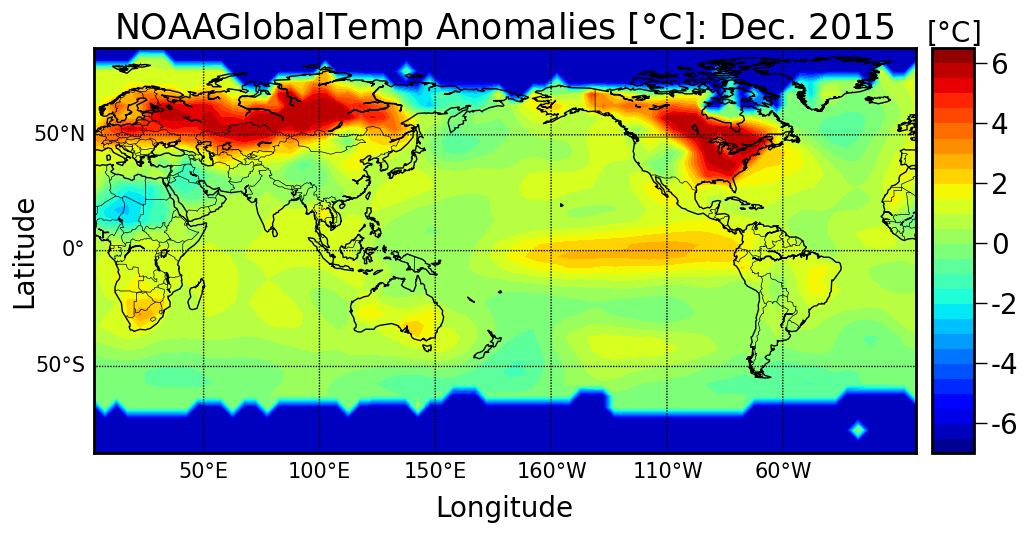

In [11]:
#Fig 11.4
# column '2015-12' corresponding to Dec 2015
# convert the vector into a lon-lat matrix for contour map plotting
# compresses numbers to [-6, 6] range
mapmat = np.reshape(gpcpst['2015-12'].values, (-1, 72)) #36 X 72
# this command compresses numbers to the range of -6 to 6
mapmat = np.maximum(np.minimum(mapmat, 6), -6)  

dpi = 100
fig = plt.figure(figsize = (1100/dpi, 1100/dpi), dpi = dpi)
ax  = fig.add_axes([0.1, 0.1, 0.8, 0.9])

# create map
dmap = Basemap(projection = 'cyl', llcrnrlat = -87.5, urcrnrlat = 87.5,
              resolution = 'c',  llcrnrlon = 2.5, urcrnrlon = 357.5)

# draw coastlines, state and country boundaries, edge of map
dmap.drawcoastlines()
# dmap.drawstates()
dmap.drawcountries()

# create and draw meridians and parallels grid lines
dmap.drawparallels(np.arange( -50, 100, 50.), labels = [1, 0, 0, 0], 
                  fontsize = 15)
dmap.drawmeridians(np.arange(50, 350, 50.), labels = [0, 0, 0, 1], 
                  fontsize = 15)

# convert latitude/longitude values to plot x/y values
# need to reverse sequence of lat1
# lat1_rev = lat1[::-1] 
lat1_rev = lat1
x, y = dmap(*np.meshgrid(lon1, lat1_rev))

# contour levels
clevs = np.arange(-7, 7, 0.5)
print(x.shape,y.shape, mapmat.shape)

# draw filled contours
cnplot = dmap.contourf(x, y, mapmat, clevs, cmap = plt.cm.jet)

# add colorbar
# pad: distance between map and colorbar
cbar = dmap.colorbar(cnplot, location = 'right', pad = "2%", ticks=[-6,-4,-2,0,2,4,6])      
cbar.ax.set_yticklabels(['-6','-4','-2','0','2','4','6'])
plt.text(362, 90, '[$\degree$C]', size=20) # add colorbar title string

# add plot title
plt.title('NOAAGlobalTemp Anomalies [$\degree$C]: Dec. 2015')

# label x and y
plt.xlabel('Longitude', labelpad = 30)
plt.ylabel('Latitude', labelpad = 40)

# display on screen
plt.show()

In [12]:
# keep only the data for the Pacific region for years from 1951-2000 

# get data for region with -20 < Latitude < 20 and 160 < Longitude < 260
n2 = gpcpst[(gpcpst['LAT'] > -20) & (gpcpst['LAT'] < 20) & 
            (gpcpst['LON'] > 160) & (gpcpst['LON'] < 260)]
print(gpcpst.shape)
print(n2.size)

# from 1951-2000 
# note Jan 1951 data starts from column 854 (note python is zero based)
pacificdat = n2.iloc[:, 854 : 1454]

(2592, 1647)
263520


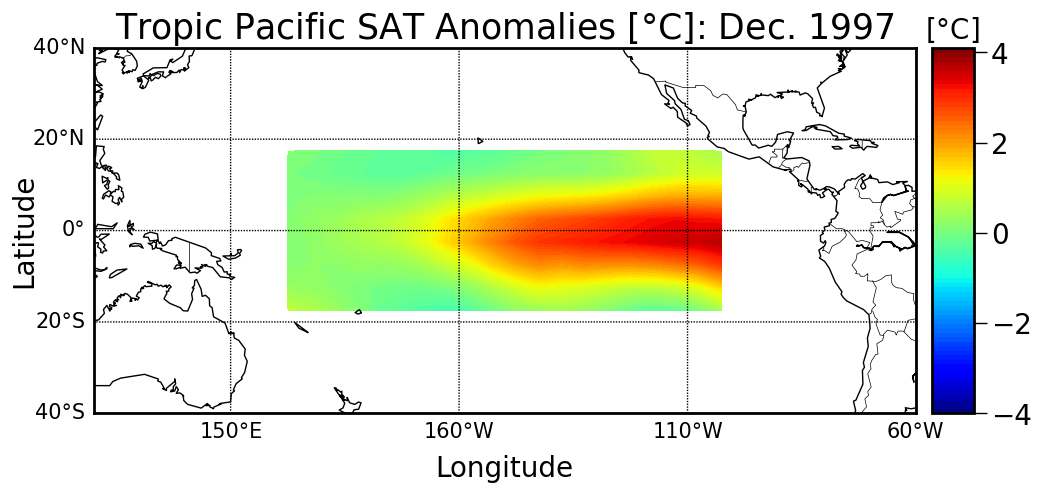

In [13]:
#Fig 11.5
Lat = np.arange(-17.5, 22.5, 5)
Lon = np.arange(162.5, 262.5, 5)

plt.close()

# get Dec 1997 data from pacificdat (tropical region)
mapmat = np.reshape(pacificdat['1997-12'].values, (8, -1)) # 8 * 20

fig = plt.figure(figsize=(1100/dpi, 1100/dpi), dpi = dpi)
ax  = fig.add_axes([0.1, 0.1, 0.8, 0.9])

# create map
smap = Basemap(projection = 'cyl', llcrnrlat = -40, urcrnrlat = 40,
              resolution = 'c', llcrnrlon = 120, urcrnrlon = 300)

# draw coastlines, state and country boundaries, edge of map
smap.drawcoastlines()
smap.drawcountries()

# create and draw meridians and parallels grid lines
smap.drawparallels(np.arange( -40, 60, 20.),labels=[1, 0, 0, 0],fontsize = 15)
smap.drawmeridians(np.arange(50, 350, 50.),labels=[0, 0, 0, 1],fontsize = 15)

# convert latitude/longitude values to plot x/y values
x, y = smap(*np.meshgrid(Lon, Lat))

# contour levels
clevs = np.arange(-4, 4.2, 0.1)

# draw filled contours
cnplot = smap.contourf(x, y, mapmat, clevs, cmap = plt.cm.jet)

# add colorbar
# pad: distance between map and colorbar
cbar = smap.colorbar(cnplot, location = 'right', pad = "2%", ticks=[-4,-2,0,2,4]) 
# add colorbar title string
plt.text(302, 42, '[$\degree$C]', size=20)

# add plot title
plt.title('Tropic Pacific SAT Anomalies [$\degree$C]: Dec. 1997')

# label x and y
plt.xlabel('Longitude', labelpad = 30)
plt.ylabel('Latitude', labelpad = 40)

# display on screen
plt.show()

_____
# 11.3 Spatial Averages and Their Trends
______

In [14]:
# prepare the data
temp = gpcpst.copy()
areaw = np.zeros((2592, 1647))
areaw.shape 
areaw[:, 0] = temp['LAT'].values
areaw[:, 1] = temp['LON'].values
# convert degrees to radians 
veca=np.cos(temp['LAT'].values * np.pi / 180).tolist()
tempvalues = temp.values # get the underlying ndarray from the temp DataFrame
# area-weight matrix equal to cosine lat of the boxes with data 
# and to zero for the boxes of missing data -999.9
for j in range(2, 1647):
    for i in range(0, 2592):
        if tempvalues[i, j] > -290.0:
            areaw[i][j] = veca[i]


In [15]:
# area-weight data matrix first two columns as lat-lon
# create monthly global average vector for 1645 months (Jan 1880 - Jan 2017)
tempw = np.multiply(areaw, tempvalues)
tempw[:,0] = temp['LAT'].values
tempw[:,1] = temp['LON'].values
avev = np.divide(tempw.sum(axis=0)[2:1647], areaw.sum(axis = 0)[2:1647])

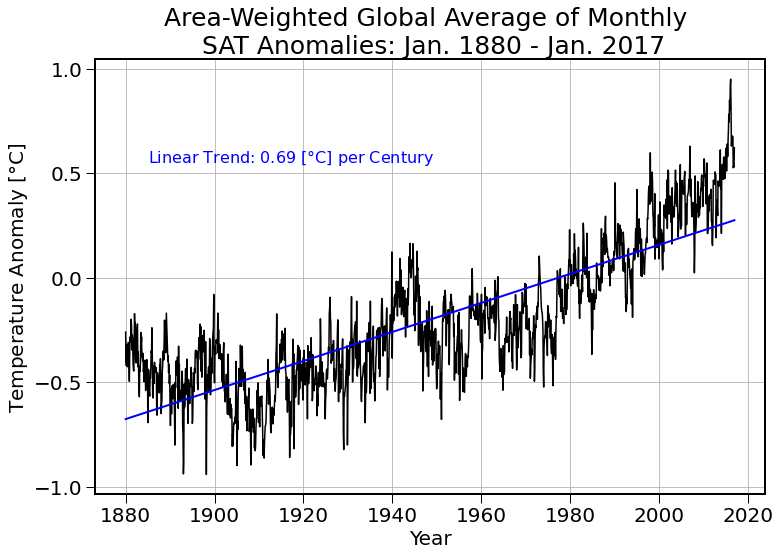

In [16]:
#Fig 11.6
plt.close()

# create time variable 
timemo = np.linspace(1880, 2017, 1645)

# create plot and plot labels 
plt.plot(timemo, avev, '-', color="k")
plt.title('Area-Weighted Global Average of Monthly \n SAT Anomalies: Jan. 1880 - Jan. 2017')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly [$\degree$C]')

plt.yticks([-1,-0.5,0,0.5,1])

# create linear regression model
lm = LinearRegression()
lm.fit(timemo.reshape(-1, 1), avev)
predictions = lm.predict(timemo.reshape(-1, 1))

# plot linear regression model
plt.plot(timemo, predictions, '-', color="blue",linewidth=2)


# add text indicating the trend 
plt.text(1885, .55, 'Linear Trend: 0.69 [$\degree$C] per Century', fontsize=16, color="blue")
plt.grid()
plt.show()  

In [17]:
gpcpst

,LAT,LON,1880-1,1880-2,1880-3,1880-4,1880-5,1880-6,1880-7,1880-8,...,2016-4,2016-5,2016-6,2016-7,2016-8,2016-9,2016-10,2016-11,2016-12,2017-1
0,-87.5,2.5,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,...,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9
1,-87.5,7.5,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,...,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9
2,-87.5,12.5,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,...,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9
3,-87.5,17.5,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,...,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9
4,-87.5,22.5,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,...,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2587,87.5,337.5,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,...,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9
2588,87.5,342.5,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,...,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9
2589,87.5,347.5,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,...,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9
2590,87.5,352.5,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,...,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9


In [18]:
# Edmonton, Canada
n2_0 = set(np.where(gpcpst.LAT == 52.5)[0])
n2_1 = set(np.where(gpcpst.LON == 247.5)[0])
print(n2_0.intersection(n2_1))

# San Diego, USA
n2_3 = set(np.where(gpcpst.LAT == 32.5)[0])
n2_4 = set(np.where(gpcpst.LON == 242.5)[0])
print(n2_3.intersection(n2_4))

{2065}
{1776}


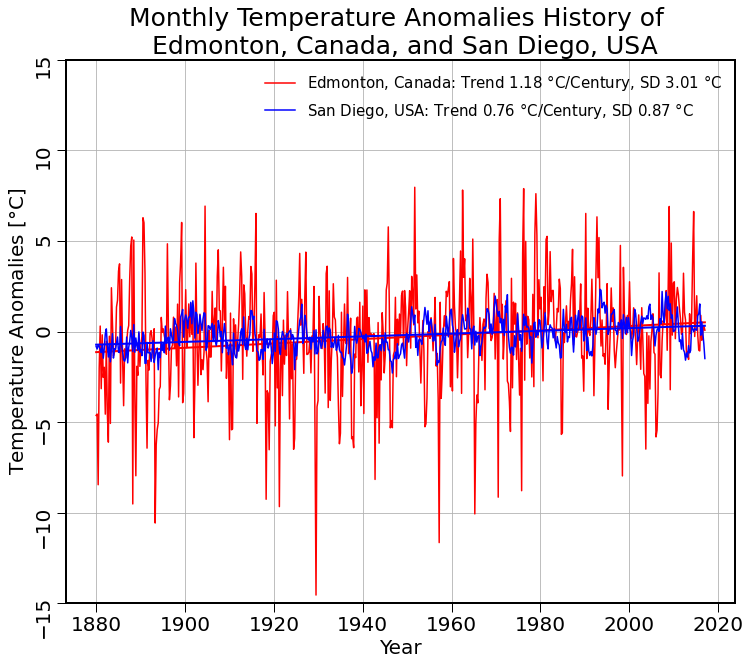

In [19]:
#Fig 11.7
# extract data for a specified box with given lat and lon
n2 = 2065
dedm = gpcpst.iloc[n2,854:1453]
t = np.linspace(1880,2017, len(dedm))

# set up figure and plot Edmonton data
fig = plt.figure(figsize=(12,10))
plt.plot(t, dedm, "red", label="Edmonton, Canada: Trend 1.18 $\degree$C/Century, SD 3.01 $\degree$C")

# set plot labels
plt.title("Monthly Temperature Anomalies History of \n Edmonton, Canada, and San Diego, USA")
plt.ylabel("Temperature Anomalies [$\degree$C]")
plt.xlabel("Year")
plt.ylim((-15,15))
plt.yticks(rotation=90)

# plot linear regression
lm = LinearRegression()
lm.fit(t.reshape(-1, 1), dedm)
predictions = lm.predict(t.reshape(-1, 1))
plt.plot(t, predictions, '-', color="red", linewidth = 2)

# create San Diego Data 
n2 = 1776
dsan = gpcpst.iloc[n2,854:1453]
t = np.linspace(1880,2017, len(dsan))

# plot san diego data 
plt.plot(t, dsan, "blue", label="San Diego, USA: Trend 0.76 $\degree$C/Century, SD 0.87 $\degree$C")

# plot linear regression
lmsan = LinearRegression()
lmsan.fit(t.reshape(-1, 1), dsan)
predictions = lmsan.predict(t.reshape(-1, 1))
plt.plot(t, predictions, '-', color="blue", linewidth = 2)

plt.legend()
plt.grid()
plt.show()

In [20]:
# print linear model coefficients and standard deviation of each data set
print(lm.coef_)
print(lmsan.coef_)
print(np.std(dedm))
print(np.std(dsan))

[0.01200846]
[0.00760766]
3.0049052677575125
0.8650167715422953


In [21]:
# download the NCEI spatial average time series of monthly data
# https://www1.ncdc.noaa.gov/pub/data/noaaglobaltemp/operational/
# timeseries/aravg.mon.land_ocean.90S.90N.v4.0.1.201702.asc
aveNCEI = pd.read_table('http://shen.sdsu.edu/data/' + 
                        'aravg.mon.land_ocean.90S.90N.v4.0.1.201703.asc.txt', 
                        header = None, delim_whitespace = True)
aveNCEI.shape 

aveNCEI = aveNCEI.values

In [22]:
print(aveNCEI.shape) #(1647,10)

# create a time variable that spans the needed years
timeo = np.linspace(aveNCEI[0,0], aveNCEI[-1,0],len(aveNCEI[:,0]))

# create a matrix of 136 years of data matrix
# row = year from 1880 to 2016 column = month 1 to 12
ave = aveNCEI[:,2]
myear = len(ave)/12
nyear = int(np.floor(myear))
nmon = nyear*12

# reshape the monthly averages into a matrix
avem = ave[0:nmon].reshape((137,12))

# compute annual average 
annv = np.zeros(137)
for i in range(0,nyear):
    annv[i] = np.mean(avem[i,:])

# put the monthly averages and annual ave in a matrix
avemy = pd.DataFrame(avem)

# add a column that indicated the averages 
avemy["Average"] = annv

(1647, 10)


In [23]:
avemy

,0,1,2,3,4,5,6,7,8,9,10,11,Average
0,-0.254882,-0.390030,-0.414509,-0.314104,-0.327618,-0.421961,-0.386787,-0.303434,-0.307535,-0.395433,-0.490574,-0.357690,-0.363713
1,-0.281037,-0.298598,-0.256906,-0.201682,-0.233895,-0.348272,-0.274636,-0.282329,-0.395464,-0.437131,-0.444607,-0.331158,-0.315476
2,-0.174060,-0.240485,-0.210161,-0.390328,-0.408842,-0.392581,-0.300641,-0.236459,-0.217395,-0.425229,-0.352755,-0.452639,-0.316798
3,-0.524041,-0.563601,-0.419921,-0.443575,-0.402770,-0.259521,-0.315984,-0.278074,-0.370997,-0.376471,-0.392778,-0.358323,-0.392171
4,-0.445016,-0.421579,-0.493839,-0.453975,-0.390322,-0.447676,-0.534206,-0.499795,-0.449471,-0.386881,-0.494061,-0.428869,-0.453807
...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,0.165989,0.153761,0.240487,0.463265,0.463908,0.455566,0.453870,0.445553,0.501094,0.490923,0.488859,0.185138,0.375701
133,0.331214,0.365247,0.333766,0.292351,0.456119,0.433921,0.435057,0.435280,0.463543,0.466267,0.605887,0.420357,0.419917
134,0.435523,0.207236,0.486705,0.530473,0.535486,0.511096,0.465122,0.572558,0.567807,0.571151,0.466506,0.553309,0.491914
135,0.558792,0.613820,0.617789,0.507067,0.599994,0.633337,0.574553,0.645725,0.705505,0.774835,0.738430,0.836829,0.650556


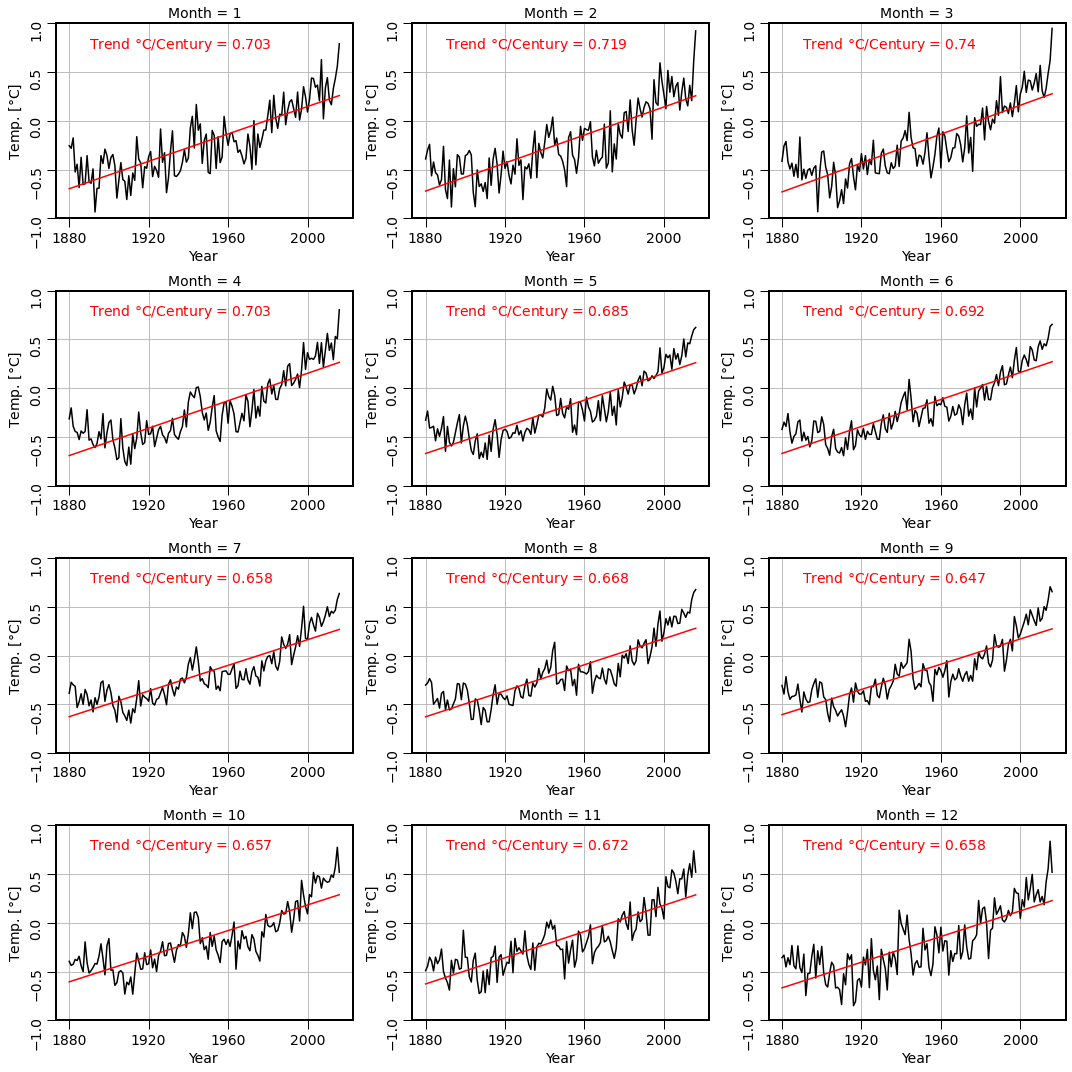

In [24]:
#Fig 11.8
# plot 12 panels on the same figure: Trend for each month
fig = plt.figure(figsize=(15,15))

# create time variable
timeyr = np.linspace(aveNCEI[0,0],aveNCEI[0,0]+nyear-1, 137)

# locate and plot each month on seperate panels
for i in range(0,12):
    plt.subplot(4,3,i+1)
    plt.plot(timeyr, avemy.iloc[:,i], color="black")
    plt.title("Month = {}".format(i+1), size=14)
    plt.yticks(rotation=90)
    plt.ylabel("Temp. [$\degree$C]", size=14)
    plt.xlabel("Year", size=14)
    
    #plot linear regression
    lm = LinearRegression()
    lm.fit(timeyr.reshape(-1, 1), avemy.iloc[:,i])
    predictions = lm.predict(timeyr.reshape(-1, 1))
    plt.plot(timeyr, predictions, '-', color="red")
    plt.text(1890,0.75, "Trend $\degree$C/Century = {}".format(np.round(lm.coef_,5)[0]*100), size=14, color="red")
    plt.grid()
    plt.ylim((-1,1))
    plt.xticks([1880,1920,1960,2000], size =14)
    plt.yticks([-1,-0.5,0,0.5,1], size =14)

# allows no overlap betweeen monthly plots
plt.tight_layout()    

plt.show()

In [25]:
# create the differenced data
avediff = np.subtract(avev, aveNCEI[0:1645, 2]) 

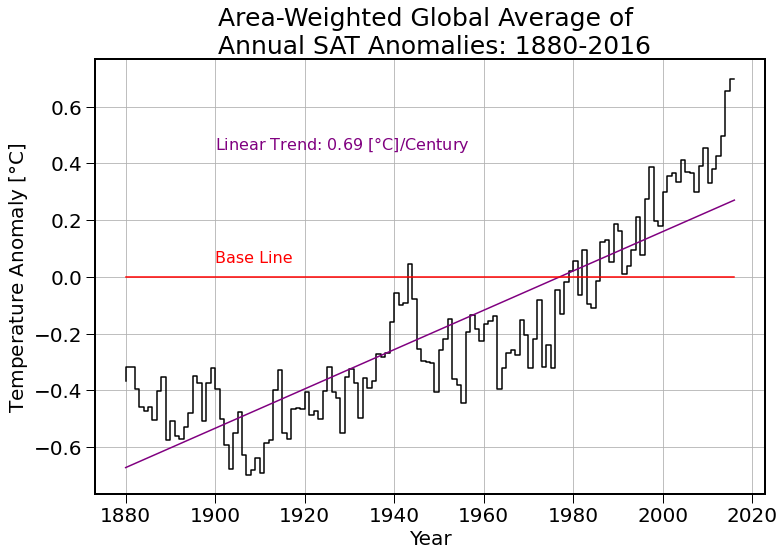

In [26]:
#Fig 11.9
# compute annual average, then plot the annual mean global average temp
avem = np.reshape(avev[0 : 1644], (-1, 12)) 
avem.shape #size 137 * 12, with row for the year, column for the month

# average over columns (annual average over 12 months), 
# there are 137 years, 1880/01 - 2016/12
annv = np.mean(avem, axis = 1)  

# plot the annual mean global average temp (1880-1996)
timeyr = np.arange(1880, 2017)

plt.close()
plt.step(timeyr, annv, '-', color="black")
plt.title('Area-Weighted Global Average of \n Annual SAT Anomalies: 1880-2016')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly [$\degree$C]')

# plot linear regression
lm = LinearRegression()
lm.fit(timeyr.reshape(-1, 1), annv)
predictions = lm.predict(timeyr.reshape(-1 , 1))

plt.plot(timeyr, predictions, '-', color="purple")


# create text on plot
plt.text(1900, .45, 'Linear Trend: 0.69 [$\degree$C]/Century', color="purple", fontsize=16)
plt.text(1900, 0.05, 'Base Line', color="red", fontsize=16)

# plot standard abline
plt.plot(timeyr, np.zeros(137), 'r-')
plt.grid()
plt.show()

In [27]:
# one can compare with the NOAAGlobalTemp annual time series
# there are some small differences
aveannNCEI = pd.read_table('http://shen.sdsu.edu/data/' + 
                          'aravg.ann.land_ocean.90S.90N.v4.0.1.201703.asc.txt', 
                          header = None, delim_whitespace = True)
aveannNCEI.shape 

aveannNCEI = aveannNCEI.values 
diff2 = np.subtract(annv, aveannNCEI[0 : 137, 1])

# find the value range (minimum and maximum values in diff2 array)
[np.amin(diff2, axis = 0), np.amax(diff2, axis = 0)] 

[-0.01609496875429861, 0.007508731446406958]

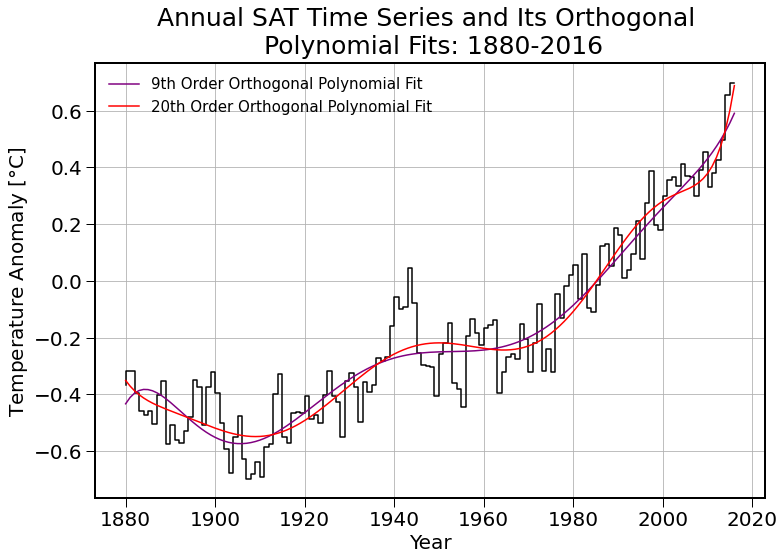

In [28]:
#Fig 11.10
# polynomial fitting to the global average annual mean
# the following polynomial fitting from numpy.polyfit is NOT orthogonal, 
# we know orthogonal polynomial fitting is usually better as we saw in the R code implemention
polyor9 = np.polyfit(timeyr, annv, 9)
polyor20 = np.polyfit(timeyr, annv, 20)

plt.close()
plt.step(timeyr, annv, '-', color="black")
plt.title('Annual SAT Time Series and Its Orthogonal \n Polynomial Fits: 1880-2016', pad = 10)
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly [$\degree$C]')

# plot the first poly fit 
plt.plot(timeyr, np.polyval(polyor9, timeyr), "-", color="purple", 
         label = "9th Order Orthogonal Polynomial Fit")

# plot the second poly fit 
plt.plot(timeyr, np.polyval(polyor20, timeyr), "-r",  
         label = "20th Order Orthogonal Polynomial Fit")

plt.legend(loc = 'upper left')
plt.grid()
plt.show()

_____
# 11.4 Spatial Characteristics of the Temperature Change Trends
______

In [29]:
# Compute the trend for each box for the 20th century
timemo1 = np.linspace(1900, 2000, 1200)
temp1 = temp.copy()

# replace missing values (any value less than -490.00) with NaN in temp1 dataframe
temp1 = temp1.where(temp1 >= -490.0, np.NaN)
trendgl = np.zeros(2592)

# for grids in (Lon: 2.5-257.5, Lat: -87.5-87.5), perform linear regression 
# fitting on each grid temperature over months between Jan 1900 and Dec 1999
# linear slope cofficient will be saved in trendgl list to be used for 
# subsequent plotting 
for i in range(0, 2592):
    if not(np.isnan(temp1.iloc[i, 242]) or np.isnan(temp1.iloc[i, 1441])): 
        # column 242 corresponds to month 1990-01, 
        # and column 1441 corresponds to month 1999-12
        # temperature data for a grid from 1990-01 to 1999-12
        gridtemp = temp1.iloc[i, 242 : 1442].values 
        # filter out any month where grid temperature is missing 
        # (i.e., having a NaN value)
        idx = np.isfinite(timemo1) & np.isfinite(gridtemp) 
        # check if there is at least one month that has 
        # non-NaN number for linear regression
        if np.any(idx[:]): 
            ab = np.polyfit(timemo1[idx], gridtemp[idx], 1)
            # ab[0] has the linear regression slope coefficient
            trendgl[i] = ab[0] 
        else:
            trendgl[i] = np.NaN
    else:
        trendgl[i] = np.NaN


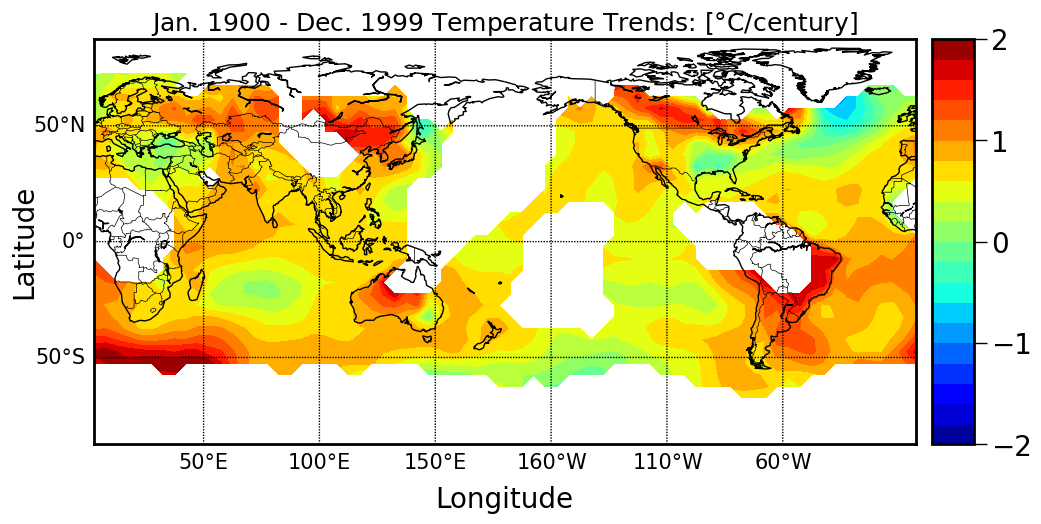

In [30]:
#Fig 11.11
mapmat = np.reshape([n * 100 for n in trendgl], (-1, 72)) #36 X 72 

# this command compresses numbers to the range of -2 to 2 
mapmat = np.maximum(np.minimum(mapmat, 2), -2) 

# set up figure
dpi = 100
fig = plt.figure(figsize = (1100 / dpi, 1100 / dpi), dpi = dpi)
ax  = fig.add_axes([0.1, 0.1, 0.8, 0.9])

# create map
amap = Basemap(projection = 'cyl', llcrnrlat = -87.5, urcrnrlat = 87.5,
              resolution = 'c',  llcrnrlon = 2.5, urcrnrlon = 357.5)

# draw coastlines, state and country boundaries, edge of map
amap.drawcoastlines()
# amap.drawstates()
amap.drawcountries()

# create and draw meridians and parallels grid lines
amap.drawparallels(np.arange( -50, 100, 50.),
                  labels = [1, 0, 0, 0], fontsize = 15)
amap.drawmeridians(np.arange(50, 350, 50.), 
                  labels = [0, 0, 0, 1], fontsize = 15)

# convert latitude/longitude values to plot x/y values
x, y = amap(*np.meshgrid(lon1, lat1))

# contour levels
clevs = np.linspace(-2, 2, 21)

# draw filled contours
cnplot = amap.contourf(x, y, mapmat, clevs, cmap = plt.cm.jet)

# add colorbar
# pad: distance between map and colorbar
cbar = amap.colorbar(cnplot, location = 'right', pad = "2%", ticks=[-2,-1,0,1,2])      
              
# add plot title
plt.title('Jan. 1900 - Dec. 1999 Temperature Trends: [$\degree$C/century]', fontsize=18)

# label x and y
plt.xlabel('Longitude', labelpad = 30)
plt.ylabel('Latitude', labelpad = 40)

plt.show()

In [31]:
# Compute trend for each box for the 20th century - Version 2: Allow 2/3 of data, i.e., 1/3 missing
# compute the trend and plot the 20C V2 trend map 
timemo1 = np.linspace(1900, 2000, 1200)
temp1 = temp.iloc[:, 242 : 1442]

# replace missing values (any value less than -490.00) 
# with NaN in temp1 dataframe
temp1 = temp1.where(temp1 >= -490.0, np.NaN)
temptf = np.isnan(temp1)

countOfNotMissing = np.zeros(2592)

# count the number of missing data points
for i in range(0, 2592):
    countOfNotMissing[i] = temptf.iloc[i, :].values.tolist().count(False)

trend20c = np.zeros(2592)
for i in range(0, 2592):
    if countOfNotMissing[i] > 800: # allow 2/3 of data, i.e., 1/3 missing
        # column 242 corresponds to month 1990-01, 
        # and column 1441 corresponds to month 1999-12
        gridtemp = temp1.iloc[i, :].values # temperature for a grid 
                                           # from 1990-01 to 1999-12
        # filter out any month where grid temperature is missing 
        # (i.e., having a NaN value)
        idx = np.isfinite(timemo1) & np.isfinite(gridtemp) 
        ab = np.polyfit(timemo1[idx], gridtemp[idx], 1)
        # ab[0] has the linear regression slope coefficient
        trend20c[i] = ab[0] 
    else:
        trend20c[i] = np.NaN
    

In [32]:
temp1.shape

(2592, 1200)

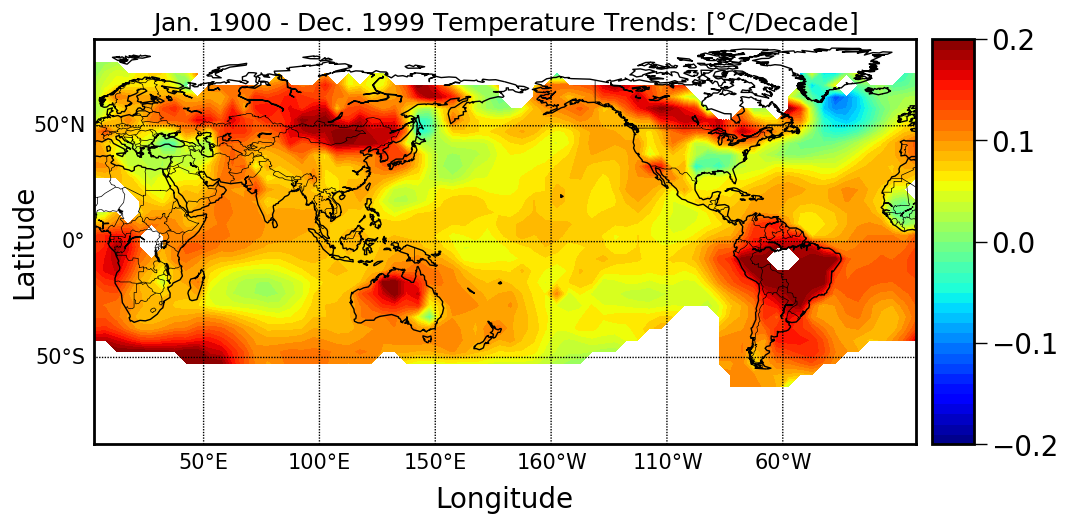

In [33]:
#Fig 11.12
mapmat = np.reshape([n * 120 for n in trend20c], (-1, 72)) #36 X 72 
mapmat = mapmat/10

# this command compresses numbers to the range of -.2 to .2
mapmat = np.maximum(np.minimum(mapmat, .2), -.2)  

dpi = 100
fig = plt.figure(figsize = (1100 / dpi, 1100 / dpi), dpi = dpi)
ax  = fig.add_axes([0.1, 0.1, 0.8, 0.9])

# create map
fmap = Basemap(projection = 'cyl', llcrnrlat = -87.5, urcrnrlat = 87.5,
              resolution = 'c',  llcrnrlon = 2.5, urcrnrlon = 357.5)

# draw coastlines and country boundaries, edge of map
fmap.drawcoastlines()
fmap.drawcountries()

# create and draw meridians and parallels grid lines
fmap.drawparallels(np.arange( -50, 100, 50.), 
                  labels = [1, 0, 0, 0], fontsize = 15)
fmap.drawmeridians(np.arange(50, 350, 50.), 
                  labels = [0, 0, 0, 1], fontsize = 15)

# convert latitude/longitude values to plot x/y values
x, y = fmap(*np.meshgrid(lon1, lat1))

# contour levels
clevs = np.linspace(-.2, .2, 41)

# draw filled contours
cnplot = fmap.contourf(x, y, mapmat, clevs, cmap = plt.cm.jet)

# add colorbar
# pad: distance between map and colorbar
cbar = fmap.colorbar(cnplot, location = 'right', pad = "2%", ticks=[0.2,0.1,0,-0.1,-0.2])      

              
# add plot title
plt.title('Jan. 1900 - Dec. 1999 Temperature Trends: [$\degree$C/Decade]', fontsize=18)

# label x and y
plt.xlabel('Longitude', labelpad = 30)
plt.ylabel('Latitude', labelpad = 40)

plt.show()

In [34]:
# compute trend for each box for the 20th century - Version 2: Allow 2/3 of data, i.e., 1/3 missing
# compute the trend and plot the 20C V2 trend map 
timemo1 = np.linspace(1976, 2016, 492)
temp1 = temp.iloc[:, 1154 : 1646]

# replace missing values (any value less than -490.00) 
# with NaN in temp1 dataframe
temp1 = temp1.where(temp1 >= -490.0, np.NaN)
temptf = np.isnan(temp1)

countOfNotMissing = np.zeros(2592)

for i in range(0, 2592):
    countOfNotMissing[i] = temptf.iloc[i, :].values.tolist().count(False)

trend20c = np.zeros(2592)
for i in range(0, 2592):
    if countOfNotMissing[i] > 320: # allow 2/3 of data, i.e., 1/3 missing
        # column 1154 corresponds to month 1976-01, 
        # and column 1646 corresponds to month 2016-12
        gridtemp = temp1.iloc[i, :].values # temperature for a grid 
                                           # from 2003-06 to 2016-12
        # filter out any month where grid temperature is missing 
        # (i.e., having a NaN value)
        idx = np.isfinite(timemo1) & np.isfinite(gridtemp) 
        ab = np.polyfit(timemo1[idx], gridtemp[idx], 1)
        # ab[0] has the linear regression slope coefficient
        trend20c[i] = ab[0] 
    else:
        trend20c[i] = np.NaN

In [35]:
temp1.shape

(2592, 492)

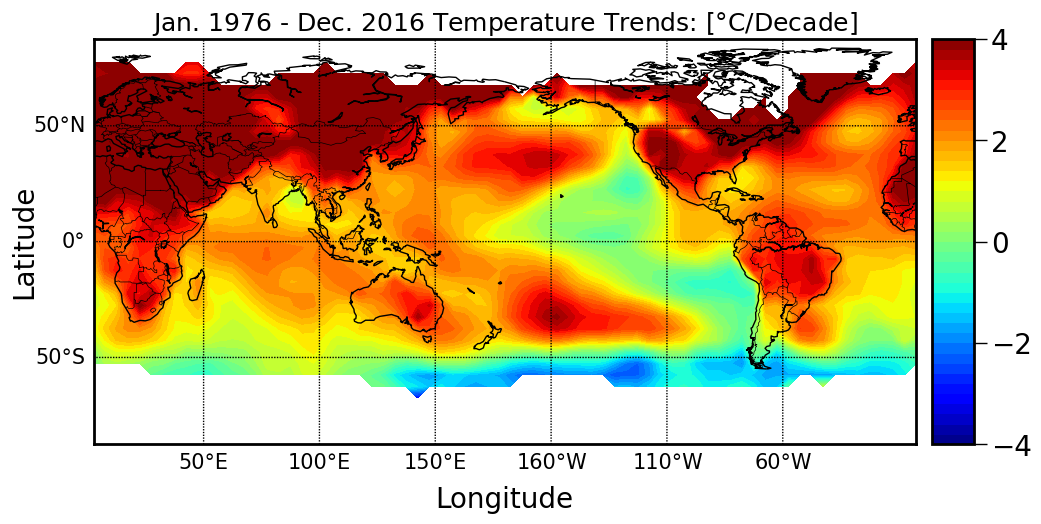

In [36]:
#Fig 11.13
mapmat = np.reshape([n * 120 for n in trend20c], (-1, 72)) #36 X 72 
# this command compresses numbers to the range of -4 to 4
mapmat = np.maximum(np.minimum(mapmat, 4), -4)  

dpi = 100
fig = plt.figure(figsize = (1100 / dpi, 1100 / dpi), dpi = dpi)
ax  = fig.add_axes([0.1, 0.1, 0.8, 0.9])

# create map
fmap = Basemap(projection = 'cyl', llcrnrlat = -87.5, urcrnrlat = 87.5,
              resolution = 'c',  llcrnrlon = 2.5, urcrnrlon = 357.5)

# draw coastlines, state and country boundaries, edge of map
fmap.drawcoastlines()
# fmap.drawstates()
fmap.drawcountries()

# create and draw meridians and parallels grid lines
fmap.drawparallels(np.arange( -50, 100, 50.), 
                  labels = [1, 0, 0, 0], fontsize = 15)
fmap.drawmeridians(np.arange(50, 350, 50.), 
                  labels = [0, 0, 0, 1], fontsize = 15)

# convert latitude/longitude values to plot x/y values
x, y = fmap(*np.meshgrid(lon1, lat1))

# contour levels
clevs = np.linspace(-4, 4, 41)

# draw filled contours
cnplot = fmap.contourf(x, y, mapmat, clevs, cmap = plt.cm.jet)

# add colorbar
# pad: distance between map and colorbar
cbar = fmap.colorbar(cnplot, location = 'right', pad = "2%", ticks=[-4,-2,0,2,4])      

              
# add plot title
plt.title('Jan. 1976 - Dec. 2016 Temperature Trends: [$\degree$C/Decade]', fontsize=18)

# label x and y
plt.xlabel('Longitude', labelpad = 30)
plt.ylabel('Latitude', labelpad = 40)

plt.show()